In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import beta
import scipy
from sklearn import preprocessing
from datetime import datetime
from datetime import date, time, datetime
import os, pandas as pd, glob
import pandas.io.common
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Under tack times are essentially an audition from prospective foals for buyers to get a measurement of a given foals speed before going to auction. The data provided is from over 10 years of OBS Auction sales data, for any sales that had a valid under tack number recorded.

https://www.obssales.com/category/obs-sales-results

In [65]:
df = pd.read_csv(r'C:\Users\Jeanne\Documents\personal\Auction Results\soldresults10yr707.csv')

The following will be an attempt to measure how the under tack time may impact a sale. The scope of the project to come will aim to predict the sales price (or some accurate measure) of racehorses at auction. Under tack times, and anything else deemed useful from the auction results, will be used in tandem with pedigree statistics to make this prediction.

In [6]:
ut = df[['OBSDate','Pricef','UTf','Siref','Damf']].dropna(subset=['UTf'])
ut.head()

,OBSDate,Pricef,UTf,Siref,Damf
380,2012-01-01,30000.0,32.2,Wildcat Heir,Silk Petticoat
381,2012-01-01,4500.0,G,Tale of the Cat,Silver Lover
382,2012-01-01,6000.0,-,Desert Warrior,Sleety
383,2012-01-01,9500.0,33,Gibson County,Slipthejab
384,2012-01-01,25000.0,46,Pure Prize,Small Vices


Select and transform all pertinent under tack time records:

In [43]:
ut['UTf'] = pd.to_numeric(ut['UTf'], errors='coerce')
ut = ut.dropna(subset=['UTf'])
ut.head()

,OBSDate,Pricef,UTf,Siref,Damf,UTfa,UTf5s,UTs,UTfs,UTa
380,2012-01-01,30000.0,32.2,Wildcat Heir,Silk Petticoat,162.0,2.0,160.0,160.0,160.4
383,2012-01-01,9500.0,33.0,Gibson County,Slipthejab,165.0,0.0,165.0,165.0,165.0
384,2012-01-01,25000.0,46.0,Pure Prize,Small Vices,230.0,0.0,230.0,230.0,230.0
391,2012-01-01,85000.0,45.0,Hard Spun,Swift Alliance,225.0,0.0,225.0,225.0,225.0
403,2012-01-01,2700.0,33.4,Graeme Hall,Adams Castle,169.0,4.0,165.0,165.0,165.8


Auction dates selected:

In [44]:
ut['OBSDate'].unique()

array(['2012-01-01', '2013-01-01', '2018-01-01', '2020-01-01',
       '2021-01-01', '2012-03-01', '2013-03-01', '2014-03-01',
       '2015-03-01', '2016-03-01', '2017-03-01', '2019-03-01',
       '2020-03-01', '2021-03-01', '2011-04-01', '2012-04-01',
       '2013-04-01', '2014-04-01', '2015-04-01', '2016-04-01',
       '2017-04-01', '2021-04-01', '2011-06-01', '2012-06-01',
       '2013-06-01', '2014-06-01', '2015-06-01', '2016-06-01',
       '2017-06-01', '2021-06-01', '2020-07-01', '2012-08-01',
       '2020-10-01', '2019-01-01', '2018-03-01', '2018-04-01',
       '2019-04-01', '2018-06-01', '2019-06-01'], dtype=object)

Plot undertack time vs price:

<AxesSubplot:xlabel='UTf', ylabel='Pricef'>

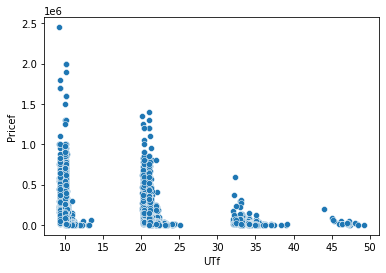

In [13]:
sns.scatterplot(x=ut['UTf'], y=ut['Pricef'])

The times vary due to multiple lengths being ran. While the OBS auction data may not indicate the length, we can intuit from the shape of this scatter plot. Times under 15 5ths of a second must be the 1/4 mile, times between 20 and 25 5ths of a second must be 1/8 mile, and so on. Let's take a closer look at just the 1/4 mile times:

In [58]:
ut10 = ut[ut['UTf'] < 15]
ut20 = ut[ut['UTf'].between(15,30)]
ut32 = ut[ut['UTf'].between(30,40)]
ut42 = ut[ut['UTf'] > 40]
uts = [ut10,ut20,ut32,ut42]

<AxesSubplot:xlabel='UTf', ylabel='Pricef'>

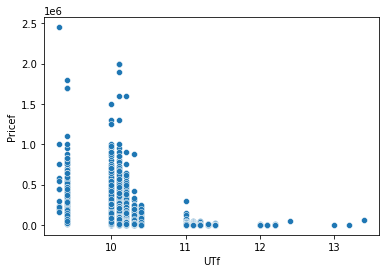

In [19]:
sns.scatterplot(x=ut10['UTf'], y=ut10['Pricef'])

Upon closer look: because the times posted by OBS are in fifths of a second, I will convert all the times to equivalent tenths of a second to make the times easier to view.

In [21]:
ut10['UTf'].unique()

array([10.1, 10.2, 11.1, 10.3, 10. , 10.4, 11. ,  9.4,  9.3, 11.2, 12.2,
       11.3, 12. , 11.4, 12.4, 13.4, 13. , 12.1, 13.2])

In [45]:
ut['UTf5s'] = (ut['UTf'] % 1) * 10
ut['UTfs'] = ut['UTf'].round(0) * 5
ut['UTfa'] = (ut['UTfs'] + ut['UTf5s']) / 5

ut10 = ut[ut['UTf'] < 15]
ut20 = ut[ut['UTf'].between(15,30)]
ut32 = ut[ut['UTf'].between(30,40)]
ut42 = ut[ut['UTf'] > 40]

The 1/4 mile times again, adjusting fractions of a second to integer values

<AxesSubplot:xlabel='UTfa', ylabel='Pricef'>

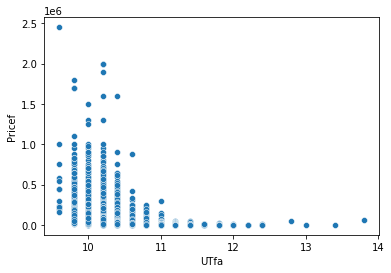

In [46]:
sns.scatterplot(x=ut10['UTfa'], y=ut10['Pricef'])

Plotting the remaining times below:

<AxesSubplot:xlabel='UTfa', ylabel='Pricef'>

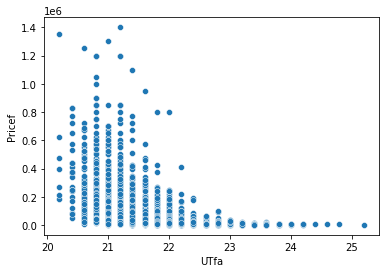

In [47]:
sns.scatterplot(x=ut20['UTfa'], y=ut20['Pricef'])

<AxesSubplot:xlabel='UTfa', ylabel='Pricef'>

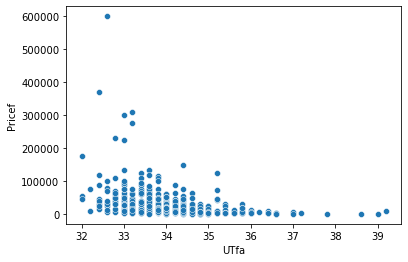

In [48]:
sns.scatterplot(x=ut32['UTfa'], y=ut32['Pricef'])

<AxesSubplot:xlabel='UTfa', ylabel='Pricef'>

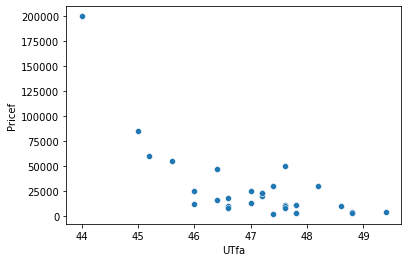

In [49]:
sns.scatterplot(x=ut42['UTfa'], y=ut42['Pricef'])

There appears to be a clear trend in undertack times to the eventual price of a foal at auction. Namely, an exponential fit should apply here. While I may want to look further into the significance of the fact that these foals ran at different distances prior to auction at some point, for the purpose of selecting a universal variable from under tack time, I will move onto summarizing all these distances into one figure.

Using z-scores to standardize each group into a comparable number:

In [50]:
import scipy.stats as stats

In [59]:
ut10['UTz'] = ut10[['UTfa']].apply(stats.zscore)
ut20['UTz'] = ut20[['UTfa']].apply(stats.zscore)
ut32['UTz'] = ut32[['UTfa']].apply(stats.zscore)
ut42['UTz'] = ut42[['UTfa']].apply(stats.zscore)
utz = pd.concat(uts)

<AxesSubplot:xlabel='UTz', ylabel='Pricef'>

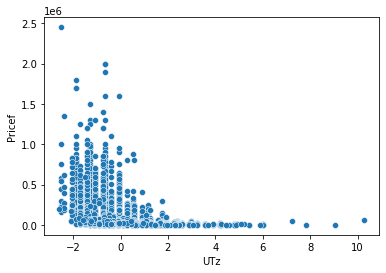

In [64]:
sns.scatterplot(x=utz['UTz'], y=utz['Pricef'])

With all the Under Tack times standardized into one number, let's observe the best fit relationship between under tack z-score and sales price.

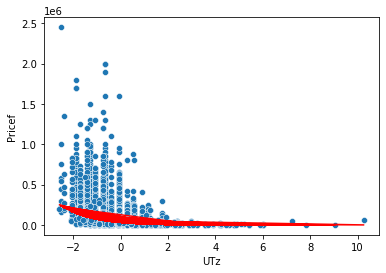

In [86]:
utz = utz.dropna(subset=['Pricef'])
x_data = utz['UTz']
y_data = utz['Pricef']
log_x = np.log(utz['UTz'])
log_y = np.log(utz['Pricef'])

curve_fit = np.polyfit(x_data, log_y, 1)
y = np.exp(curve_fit[1]) * np.exp(curve_fit[0]*x_data)
sns.scatterplot(x_data, y_data)
plt.plot(x_data, y, color='r')
plt.show()

The coefficients:

In [79]:
curve_fit

array([-0.78010351, 10.42084753])

Line of best fit: y = 10.42 + -0.78 ^ x

While I do see a promising relationship between under tack time and sales price, I am not sure the under tack time will be a strong indicator of the exact magnitude of price. I do, however, believe that a lower under tack time indicates a higher possible range of sales price allowed. In other words, an otherwise promising foal (according to pedigree and other variables) at auction may be ruled out of a strong sale if the under tack time is lacking. After a certain point, a strong under tack time allows foals to hit the highest sales price.

I still want to explore further how this relationship is best modeled, in tandem with other variables, but I will move onto some of the pedigree statistics I have collected.